This is an example of an item-item recommender system, like what you would see on Netflix.  This is also an example collaborative filtering.

# Create a virtual environment.  Optional, only needs to be done once.  MUST BE RUN IN THE TERMINAL
python -m venv .venv

# Active the environment.  On MacOS, WSL, Linux
source .venv/bin/activate
# Activiate the environment  On Windows
.\.venv\Scripts\activate

In [123]:

# install any packages that you don't have.  These only need to be run once
#%pip install matplotlib
#%pip install seaborn
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Load the data

In [156]:
base_data_path = "sample-data-20mill/"
#base_data_path = "sample-data-small/"
#base_data_path = "sample-data-large/"  # folder containing larger set of user reviews

#ratings = pd.read_csv(base_data_path + 'ratings.csv')
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [157]:
#movies = pd.read_csv(base_data_path + 'movies.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Exploratory Data Analysis

In [158]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


Distribution of movie ratings

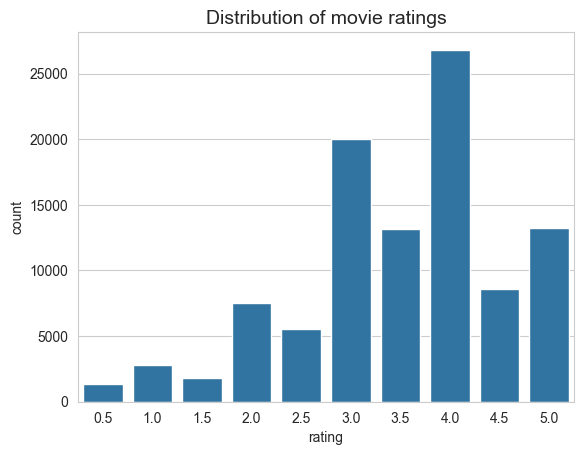

In [160]:
sns.countplot( x='rating', data=ratings)      
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [161]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

Mean global rating: 3.5.


In [162]:
mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean rating per user: 3.66.


In [163]:
# Move frequently rates movies
movie_ratings = ratings.merge(movies, on='movieId')  # merge these two so that we can bring in titles
movie_ratings['title'].value_counts()[0:10]

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

In [164]:
#Lets take a look at the user's rating counts
# user_freq = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
# user_freq.columns = ['userId', 'n_ratings']
# user_freq.head()

In [165]:
# print(f"Mean number of ratings for a given user: {user_freq['n_ratings'].mean():.2f}.")

Distribution of Ratings

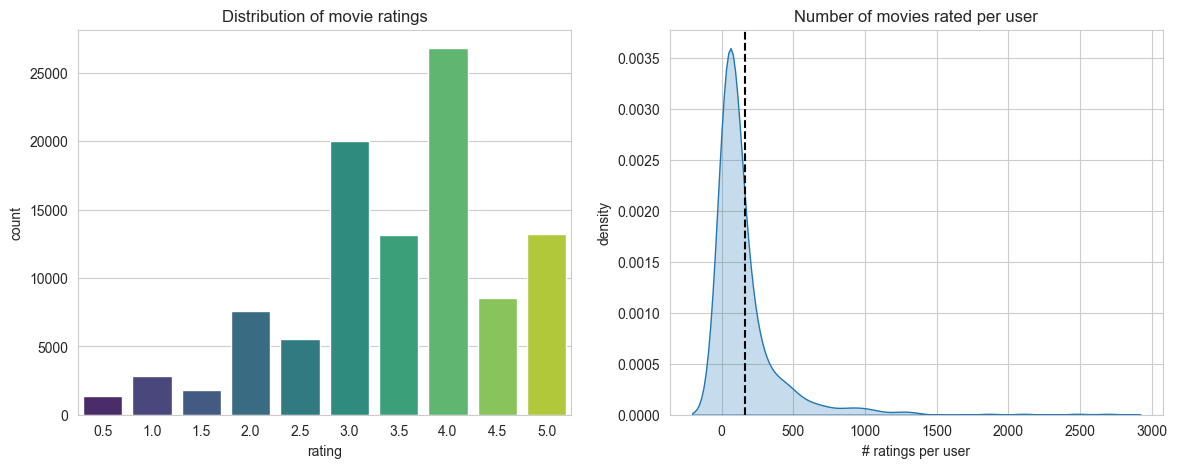

In [166]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings")

plt.subplot(1,2,2)
ax = sns.kdeplot(user_freq['n_ratings'], shade=True, legend=False)
plt.axvline(user_freq['n_ratings'].mean(), color="k", linestyle="--")
plt.xlabel("# ratings per user")
plt.ylabel("density")
plt.title("Number of movies rated per user")
plt.show()

Highest and Lowest Rated

In [167]:
mean_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rated = mean_rating['rating'].idxmin()  # get the index of the lowest rated movie
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [168]:
highest_rated = mean_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [169]:
# We found the highest rated movie in the previous step.  But how many reviews dodes it have?
ratings[ratings['movieId']==highest_rated]  # this returns the list of ratings for this movie

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


# Bayesian Average Score.  
This tries to account for movies that how low cardinality (e.g. number of reviews).  https://arpitbhayani.me/blogs/bayesian-average/

In [170]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats.head()
#movie_stats.columns = movie_stats.columns.droplevel()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [171]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

# def bayesian_avg(ratings):
#     bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
#     return bayesian_avg

# bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
# bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
# movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [172]:
# lets test this out on the lowest rated movie
lamerica = pd.Series([5,5]) # This movie had two ratings of 5 stars
bayesian_avg(lamerica)  # The result is 3.543.  Bayesian lowers because of few reviews

3.5433826131392228

In [173]:
# lets apply Bayesian average to all movies
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index() #new dataframe, reset_index allows us to put it in dataframe
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg'] # set the columns for this new dataframe
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId') # merge the two dataframes together
movie_stats.head()

,movieId,count,mean,bayesian_avg
0,1,215,3.920930,3.890632
1,2,110,3.431818,3.417227
2,3,52,3.259615,3.260086
3,4,7,2.357143,2.897612
4,5,49,3.071429,3.104793


In [174]:
# Sort descenging using the Bayesian average
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


In [175]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()  # lowest rated

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


Genres


    genres is expressed as a string with a pipe | separating each genre. We will manipulate this string into a list, which will make it much easier to analyze.
    title currently has (year) appended at the end. We will extract year from each title string and create a new column for it.


In [176]:
movies['genres'] = movies['genres'].apply(lambda x:x.split('|') )
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [177]:
# How many genres are there?
from collections import Counter  # This is a built-in python function

genre_frequency = Counter (g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Drama': 4361,
         'Comedy': 3756,
         'Thriller': 1894,
         'Action': 1828,
         'Romance': 1596,
         'Adventure': 1263,
         'Crime': 1199,
         'Sci-Fi': 980,
         'Horror': 978,
         'Fantasy': 779,
         'Children': 664,
         'Animation': 611,
         'Mystery': 573,
         'Documentary': 440,
         'War': 382,
         'Musical': 334,
         'Western': 167,
         'IMAX': 158,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [178]:
print("The 5 most common genres: \n", genre_frequency.most_common(5)) # most_common is a method in counter

The 5 most common genres: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


# left off here

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Thriller'),
  Text(3, 0, 'Action'),
  Text(4, 0, 'Romance'),
  Text(5, 0, 'Adventure'),
  Text(6, 0, 'Crime'),
  Text(7, 0, 'Sci-Fi'),
  Text(8, 0, 'Horror'),
  Text(9, 0, 'Fantasy'),
  Text(10, 0, 'Children'),
  Text(11, 0, 'Animation'),
  Text(12, 0, 'Mystery'),
  Text(13, 0, 'Documentary'),
  Text(14, 0, 'War'),
  Text(15, 0, 'Musical'),
  Text(16, 0, 'Western'),
  Text(17, 0, 'IMAX'),
  Text(18, 0, 'Film-Noir'),
  Text(19, 0, '(no genres listed)')])

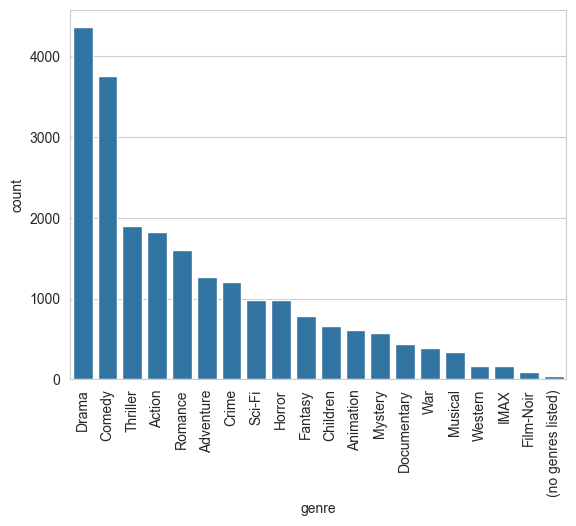

In [179]:
# "T" is for transpose.  This shifts it from a row to a column
# "reset_index" is necessary to give the index a number and not the genre name
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']

sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)  # this rotates the axis titles so they are not overlapping

Transforming the Data

We will be using collaborative filtering with a user-item matrix:  https://medium.com/@rebirth4vali/implementing-matrix-factorization-technique-for-recommender-systems-from-scratch-7828c9166d3c

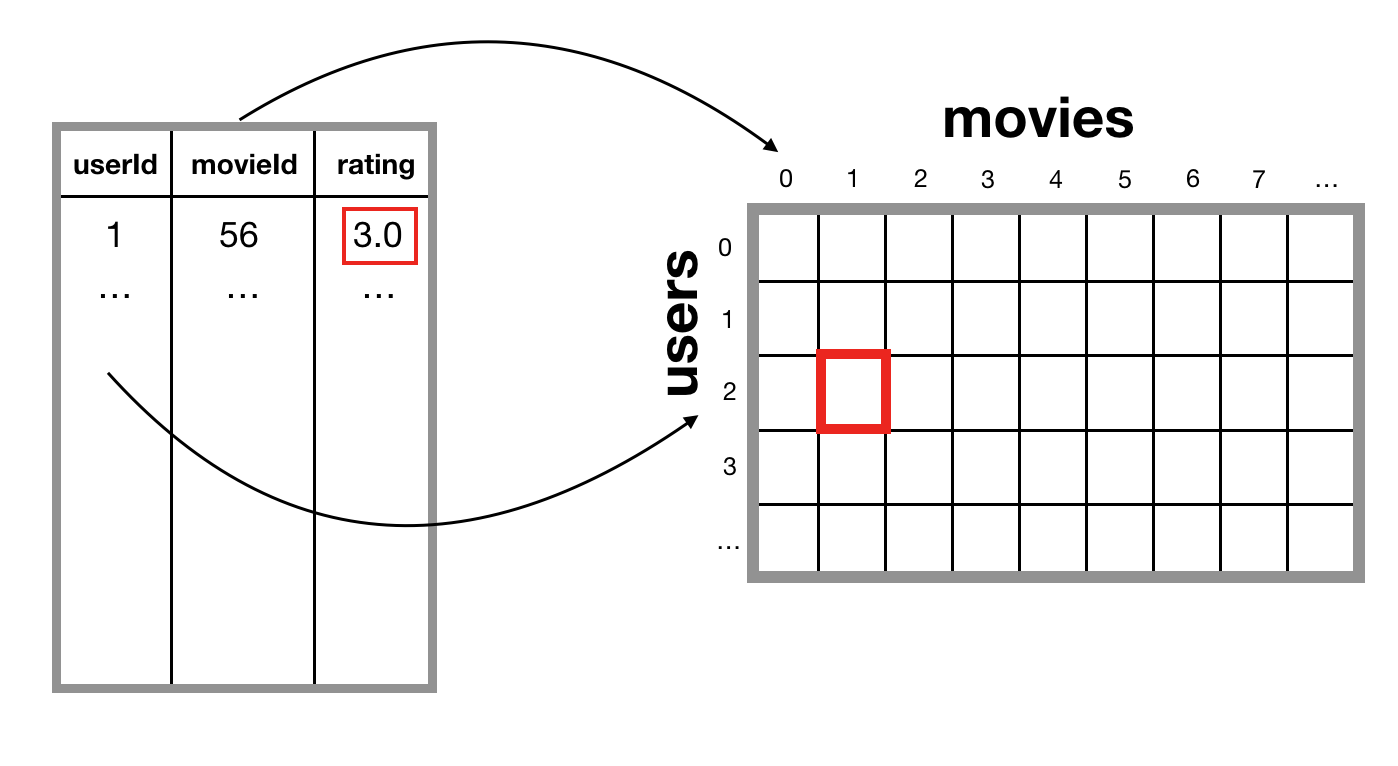


The create_X() function outputs a sparse matrix X with four mapper dictionaries:

    user_mapper: maps user id to user index
    movie_mapper: maps movie id to movie index
    user_inv_mapper: maps user index to user id
    movie_inv_mapper: maps movie index to movie id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and movie ID, respectively.

In [180]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:  4 dictionaries are created
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    
    # This gets the count of each type
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))  # this makes sure the index is right
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [181]:
X.shape


(9724, 610)

Evaluating Sparsity.  Evaluating your data to see if collaborative filtering is an option because of too few reviews.

In [182]:
n_total = X.shape[0] * X.shape[1]  # e.g. multiplying rows x columns to find number of cells in matrix
n_ratings = X.nnz # nnz counts the number of non-zero cells in matrix
sparsity = n_ratings/n_total # it is believed anything above .1 is good.  If lower, consider content-based filtering
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


The cold start problem.  When there are new users or movies in the system that do not have ratings.  

In [183]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

9724